# Hyperloop

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import inv
from scipy.stats import multivariate_normal as normal

In [2]:
plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.rcParams['font.size'] = 12.

## Parameters

In [3]:
T = 60.  # s
delta_t = 1.  # s
mu_t, sigma_t = 6.022, 1.618  # m/s²
eta = 0.05  # drag coefficient

## Markov model

### Prior

$$p(x_0) = \mathcal{N}(\mu_0, \Sigma_0)$$

In [4]:
mu_0 = np.array([0, 0, mu_t])

S_0 = np.array([
    [0.1 ** 2, 0, 0],
    [0, 0.01 ** 2, 0],
    [0, 0, sigma_t ** 2]
])

### Transition model

$$p(x_t \vert x_{t - 1}) = \mathcal{N}(A x_{t - 1} + b, S_x)$$

In [5]:
A = np.array([
    [1, delta_t, delta_t ** 2 / 2],
    [0, 1, delta_t],
    [0, -eta, -eta * delta_t]
])

b = np.array([0, 0, mu_t])

S_x = np.array([
    [0, 0, 0],
    [0, 0, 0],
    [0, 0, sigma_t ** 2]
])

### Sensor model

$$p(e_t \vert x_t) = \mathcal{N}(C x_t + d, S_e)$$

In [6]:
C = np.array([
    [1, 0, 0],
    [0, 0, 1]
])

d = np.array([0, 0])

S_e = np.array([
    [100. ** 2, 0],
    [0, 1. ** 2]
])

## Generation

In [7]:
def first():
    return normal.rvs(mu_0, S_0)

def transition(x, t):
    """eta = 0.05 + 0.003 * np.maximum(x[1] - 33, 0)
    A = np.array([
       [1, delta_t, delta_t ** 2 / 2],
       [0, 1, delta_t],
       [0, -eta, -eta * delta_t]
    ])"""
    
    return normal.rvs(A @ x + b, S_x)

def observe(x):
    return normal.rvs(C @ x + d, S_e)

In [8]:
timesteps = np.arange(0, T + delta_t, delta_t)
states = [first()]
evidences = []

for t in timesteps[1:]:
    x = states[-1]
    x = transition(x, t)
    e = observe(x)
    
    states.append(x)
    evidences.append(e)
    
states, evidences = map(np.stack, [states, evidences])

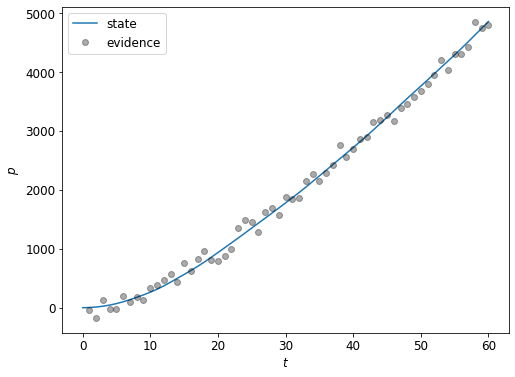

In [9]:
plt.plot(timesteps, states[:, 0], label='state')
plt.plot(timesteps[1:], evidences[:, 0], 'ko', alpha=0.33, label='evidence')

plt.xlabel('$t$')
plt.ylabel('$p$')
plt.legend()

plt.show()

## Kalman filtering

At each time step $t$, we have $\mu_{t - 1}$ and $\Sigma_{t - 1}$ such that
$$p(x_{t - 1} \vert e_{1:t - 1}) = \mathcal{N}(\mu_{t - 1}, \Sigma_{t - 1})$$ and wish to compute $\mu_t$ and $\Sigma_t$.

We know that $$p(x_t \vert x_{t - 1}) = \mathcal{N}(A x_{t - 1} + b, \Sigma_x)$$ and $$p(e_t \vert x_t) = \mathcal{N}(C x_t + d, \Sigma_e).$$

Then, using the cheat sheet for Gaussian models (slide 51, lecture 6),

$$p(x_t \vert e_{1:t}) = \mathcal{N}(\mu_t, \Sigma_t)$$

where

$$\Sigma_* = \Sigma_x + A \Sigma_{t - 1} A^T$$
$$\mu_* = A \mu_{t-1} + b$$
$$\Sigma_t = (\Sigma_*^{-1} + C^T \Sigma_e^{-1} C)^{-1}$$
$$\mu_t = \Sigma_t (C^T \Sigma_e^{-1} (e_t - d) + \Sigma_*^{-1} \mu_*) .$$

In [10]:
beliefs = [(mu_0, S_0)]

for e in evidences:
    mu, S = beliefs[-1]
    
    S_star = S_x + A @ S @ A.T
    mu_star = A @ mu + b
    
    S = inv(inv(S_star) + C.T @ inv(S_e) @ C)
    mu = S @ (C.T @ inv(S_e) @ (e - d) + inv(S_star) @ mu_star)
    
    beliefs.append((mu, S))

mus, Ss = map(np.stack, zip(*beliefs))
sigmas = np.sqrt(Ss[:, np.arange(3), np.arange(3)])  # diagonal elements

### Position

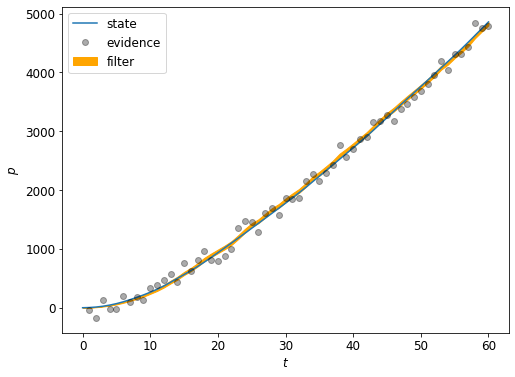

In [11]:
plt.plot(timesteps, states[:, 0], label='state')
plt.plot(timesteps[1:], evidences[:, 0], 'ko', alpha=0.33, label='evidence')
plt.fill_between(timesteps, mus[:, 0] - sigmas[:, 0], mus[:, 0] + sigmas[:, 0], color='orange', label='filter')

plt.xlabel('$t$')
plt.ylabel('$p$')
plt.legend()

plt.show()

### Speed

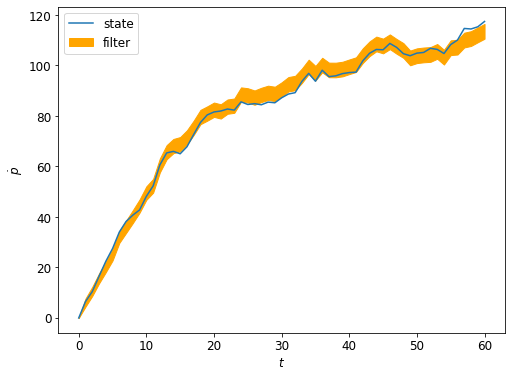

In [12]:
plt.plot(timesteps, states[:, 1], label='state')
plt.fill_between(timesteps, mus[:, 1] - sigmas[:, 1], mus[:, 1] + sigmas[:, 1], color='orange', label='filter')

plt.xlabel('$t$')
plt.ylabel('$\dot{p}$')
plt.legend()

plt.show()

### Acceleration

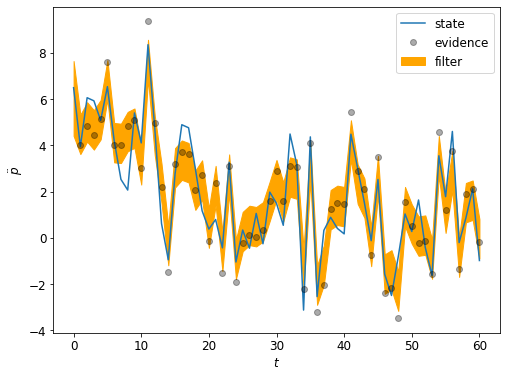

In [13]:
plt.plot(timesteps, states[:, 2], label='state')
plt.plot(timesteps[1:], evidences[:, 1], 'ko', alpha=0.33, label='evidence')
plt.fill_between(timesteps, mus[:, 2] - sigmas[:, 2], mus[:, 2] + sigmas[:, 2], color='orange', label='filter')

plt.xlabel('$t$')
plt.ylabel('$\ddot{p}$')
plt.legend()

plt.show()